# Requirements

In [20]:
#pip install -r requirements.txt
#pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu126

# Generate ARMAX model

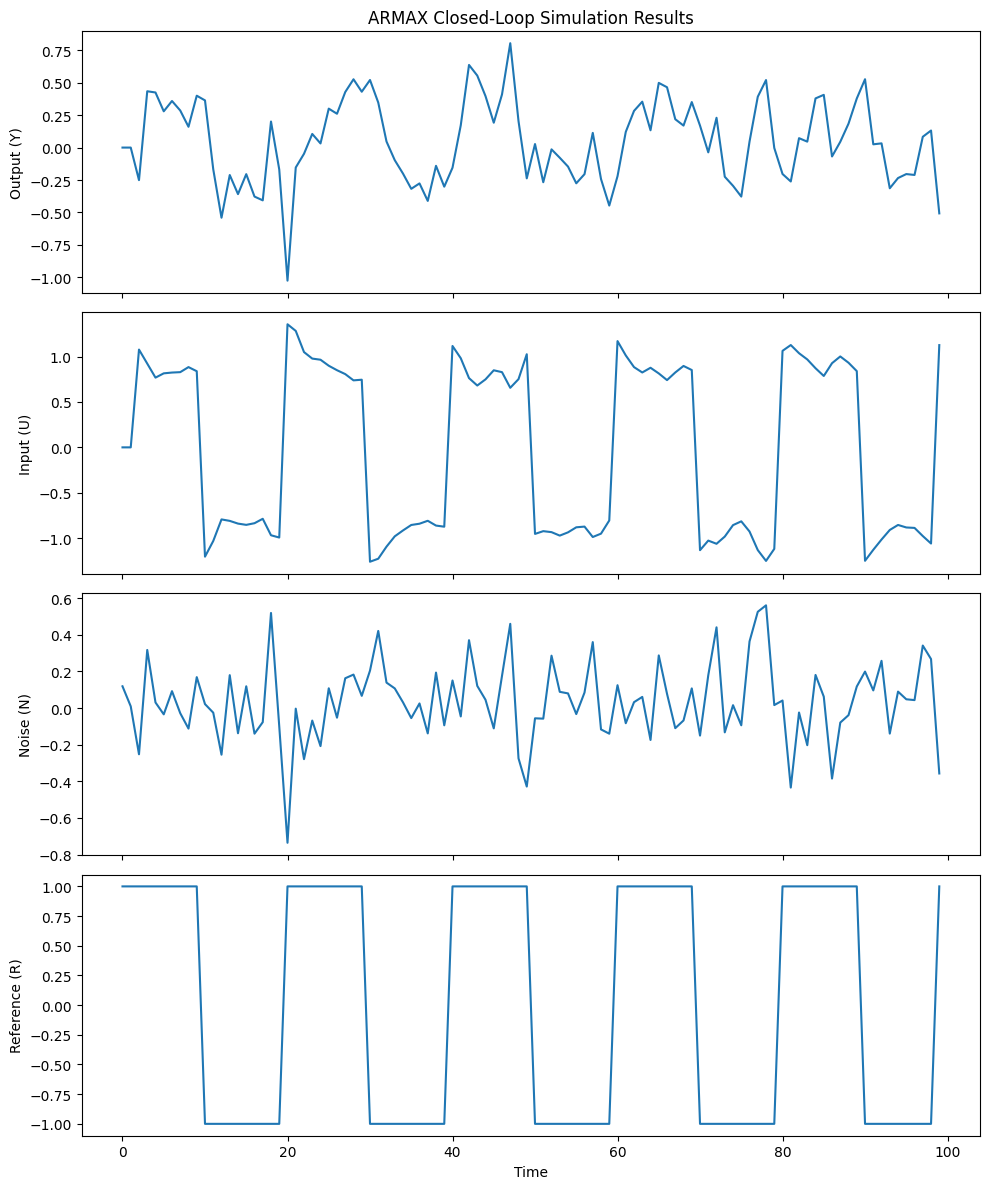

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
        self.F = np.array(F)
        self.L = np.array(L)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = np.zeros(n_samples)
        U = np.zeros(n_samples)
        N = np.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- np.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (np.dot(self.L, R[t:t-len(self.L):-1]) 
                    - np.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
# square wave reference signal
R = signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
armax_model.plot_results(Y, U, N, R)


# Indirect SPS Implementation

In [18]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cub'

In [ ]:
# import os
# os.environ['CUPY_ACCELERATORS'] = 'cub'
import torch
try:
    torch.cuda.current_device()
    import cupy as cp
    from cupyx.scipy.linalg import solve_triangular
    from cupyx.scipy.signal import lfilter
    device = 'cuda'
except:
# Fall back to unoptimised versions
    import numpy as cp
    from scipy.linalg import solve_triangular
    from scipy.signal import lfilter
    device = None
    
cp.random.seed(42)
class d_tfs:
    def __init__(self, A):
        self.epsilon = cp.float64(1e-10)
        self.num = cp.asarray(A[0]).astype(self.epsilon.dtype)  # Ensure CuPy array
        self.den = cp.asarray(A[1]).astype(self.epsilon.dtype)   # Ensure CuPy array

    def __mul__(self, other):
        num = cp.convolve(self.num, other.num)  # Use cp.convolve for efficiency
        den = cp.convolve(self.den, other.den)
        return d_tfs((num, den))

    def add_scalar(self, scalar):
        # Multiply the denominator by the scalar
        scalar_denom = scalar * self.den
        # Ensure both polynomials have the same length by padding with zeros at the back
        if len(self.num) > len(scalar_denom):
            scalar_denom = cp.pad(scalar_denom, (0, len(self.num) - len(scalar_denom)))
        elif len(self.num) < len(scalar_denom):
            self.num = cp.pad(self.num, (0, len(scalar_denom) - len(self.num)))
        # Add the polynomials
        num_with_scalar = cp.polyadd(self.num, scalar_denom)
        return d_tfs((num_with_scalar, self.den))

    def __truediv__(self, other):
        num = cp.convolve(self.num, other.den)
        den = cp.convolve(self.den, other.num)
        return d_tfs((num, den))

    def __invert__(self):
        return d_tfs((self.den, self.num))

    def __str__(self):
        return f"Transfer Function: num={self.num}, den={self.den}"

    def __repr__(self):
        return self.__str__()

    def __call__(self, z):
        return cp.polyval(self.num, z) / cp.polyval(self.den, z)

    def apply_shift_operator(self, U_t):
        try:
            # Ensure input is a CuPy array
            U_t = cp.asarray(U_t)
            self.num += self.epsilon  # Add epsilon to avoid division by zero
            self.den += self.epsilon  # Add epsilon to avoid division by zero
            Y_t = lfilter(self.num, self.den, U_t)  # Use lfilter for filtering
            return cp.asarray(Y_t)
        except Exception as e:
            raise ValueError(f"Error applying shift operator: {e}")


class SPS_indirect_model:
    def __init__(self, m, q, N=50):
        self.N = N
        self.m = m
        self.q = q
        self.alpha = cp.random.randn(m,N)
        self.alpha = cp.sign(self.alpha)
        self.alpha[0, :] = 1
        self.pi_order = cp.random.permutation(cp.arange(m))

    def create_phi_optimized(self, Y, U, n_a, n_b):
        m, t = Y.shape
        
        # Initialize phi with zeros
        phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
        
        # Handle Y lags
        for i in range(1, n_a + 1):
            phi[:, i:, i-1] = -1*Y[:, :-i]
        
        # Handle U lags
        for i in range(1, n_b + 1):
            phi[:, i:, n_a+i-1] = U[:-i]
        
        return phi

    def transform_to_open_loop(self, G, H, F, L):
        G = d_tfs(G)
        H = d_tfs(H)
        F = d_tfs(F)
        L = d_tfs(L)

        GF_plus_I = (G * F).add_scalar(1)
        i_GF_plus_I = ~GF_plus_I
        G_0 = i_GF_plus_I * G * L
        H_0 = i_GF_plus_I * H
        return G_0, H_0

    def open_loop_sps(self, G_0, H_0, Y_t, U_t, n_a, n_b):
        try:
            Y_t = cp.asarray(Y_t)
            U_t = cp.asarray(U_t)
            YGU = Y_t - G_0.apply_shift_operator(U_t)
            N_hat = (~H_0).apply_shift_operator(YGU)

            # last N data points
            N_hat_par = N_hat[-self.N:]
            U_t_par = U_t[-self.N-1:-1]
            
            perturbed_N_hat = cp.multiply(self.alpha, N_hat_par)
            y_bar = [
                G_0.apply_shift_operator(U_t_par) + H_0.apply_shift_operator(perturbed_N_hat[i])
                for i in range(self.m)
            ]

            y_bar = cp.array(y_bar)
            phi_tilde = self.create_phi_optimized(y_bar, U_t_par, n_a, n_b)
            S = cp.zeros(self.m)
            for i in range(self.m):
                phi_col = phi_tilde[i]
                R_i = cp.matmul(phi_col.T, phi_col) / len(Y_t)
                L = cp.linalg.cholesky(R_i)  # Cholesky decomposition to get lower-triangular L
                R_root_inv = solve_triangular(L, cp.eye(L.shape[0]), lower=True)  # Compute L_inv
                weighted_sum = cp.matmul(phi_tilde[i].T,perturbed_N_hat[i].reshape(-1,1))
                # norm squared
                S[i] = cp.sum(cp.square(cp.matmul(R_root_inv, weighted_sum)))

            combined = cp.array(list(zip(self.pi_order, S)))
            order= cp.lexsort(combined.T)
            rank_R = cp.where(order == 0)[0][0] + 1
            return rank_R <= self.m - self.q , S
        except Exception as e:
            raise ValueError(f"Error in open-loop SPS: {e}")
    
    def open_loop_sps_2(self, G_0, H_0, Y_t, U_t, n_a, n_b):
        try:
            Y_t = cp.asarray(Y_t)
            U_t = cp.asarray(U_t)
            YGU = Y_t - G_0.apply_shift_operator(U_t)
            N_hat = (~H_0).apply_shift_operator(YGU)
            
            # Extract relevant segments
            N_hat_par = N_hat[-self.N:]
            U_t_par = U_t[-self.N-1:-1]
            perturbed_N_hat = cp.multiply(self.alpha, N_hat_par)
            
            # Compute y_bar vectorized
            y_bar = G_0.apply_shift_operator(U_t_par)[None, :] + H_0.apply_shift_operator(perturbed_N_hat[:, None])
            y_bar = y_bar.transpose(1, 0, 2)[0]
            # Compute phi_tilde
            phi_tilde = self.create_phi_optimized(y_bar, U_t_par, n_a, n_b)
            # Compute Cholesky decomposition and norm squared
            R = cp.matmul(phi_tilde.transpose(0, 2, 1), phi_tilde) / len(Y_t)
            L = cp.linalg.cholesky(R)
            Q, R = cp.linalg.qr(L)
            R_root_inv = cp.linalg.solve(R, Q.transpose(0, 2, 1))
            weighted_sum = cp.matmul(phi_tilde.transpose(0, 2, 1), perturbed_N_hat[:, :, None])
            S = cp.sum(cp.square(cp.matmul(R_root_inv, weighted_sum)), axis=(1, 2))
            # Ranking
            combined = cp.array(list(zip(self.pi_order, S)))
            order = cp.lexsort(combined.T)
            rank_R = cp.where(order == 0)[0][0] + 1
            
            return rank_R <= self.m - self.q, S
        except Exception as e:
            raise ValueError(f"Error in open-loop SPS: {e}")
# Example usage with CuPy:
A  = [1, -0.33] # A(z^-1) = 1 - 0.33z^-1
B = [0, 0.22]  # B(z^-1) = 0.22z^-1
C = [1, 0.15] # C(z^-1) = 1 + 0.15z^-1

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

m = 100
q = 5
T = n_samples  # Example sample size

import cProfile, pstats
profiler = cProfile.Profile()

model = SPS_indirect_model(m, q)
G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
# open loop system is 
# Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t
profiler.enable()
in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=R, n_a=1, n_b=1)
# print(f"SPS: {in_sps}")

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
profiler.clear()


         72801 function calls (72799 primitive calls) in 0.532 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.532    0.266 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        2    0.000    0.000    0.532    0.266 {built-in method builtins.exec}
        1    0.000    0.000    0.532    0.532 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:1(<module>)
        1    0.039    0.039    0.532    0.532 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:106(open_loop_sps)
      202    0.023    0.000    0.329    0.002 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:56(apply_shift_operator)
      202    0.084    0.000    0.304    0.002 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupyx\scipy\signal\_signaltools.py:642(lf

## Indirect SPS testing

In [20]:
profiler = cProfile.Profile()
profiler.enable()
in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=R, n_a=1, n_b=1)
# print(f"SPS: {in_sps}")

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
profiler.clear()

         72853 function calls (72852 primitive calls) in 0.549 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.548    0.274 {built-in method builtins.exec}
        1    0.001    0.001    0.548    0.548 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\3842388970.py:1(<module>)
        1    0.046    0.046    0.546    0.546 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:106(open_loop_sps)
      202    0.027    0.000    0.316    0.002 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:56(apply_shift_operator)
      202    0.048    0.000    0.286    0.001 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupyx\scipy\signal\_signaltools.py:642(lfilter)
      202    0.032    0.000    0.152    0.001 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupyx\scipy\signal\_iir_utils.py:532(app

In [29]:
profiler2 = cProfile.Profile()
profiler2.enable()
in_sps, S2 = model.open_loop_sps_2(G_0=G_0, H_0=H_0, Y_t=Y, U_t=R, n_a=1, n_b=1)
print(f"SPS: {in_sps}")
profiler2.disable()
stats = pstats.Stats(profiler2).sort_stats('cumtime')
stats.print_stats()
print(cp.allclose(S1, S2))

SPS: True
         3455 function calls (3448 primitive calls) in 0.077 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.076    0.025 {built-in method builtins.exec}
        1    0.004    0.004    0.075    0.075 C:\Users\mukul\AppData\Local\Temp\ipykernel_19856\532530477.py:142(open_loop_sps_2)
       34    0.024    0.001    0.027    0.001 {built-in method cupy._core.core.array}
       21    0.000    0.000    0.027    0.001 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\_creation\from_data.py:7(array)
        1    0.000    0.000    0.026    0.026 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\linalg\_decomposition.py:263(qr)
        1    0.000    0.000    0.026    0.026 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\linalg\_decomposition.py:225(_q

In [16]:
import numpy as np

state = np.array([0.0, 0.0, np.pi/4 + 0.1, 0.0])
observable = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
# only get the observable states by multiplying the state with the observable matrix
o_state = observable @ state

print(o_state)


[0.         0.88539816]


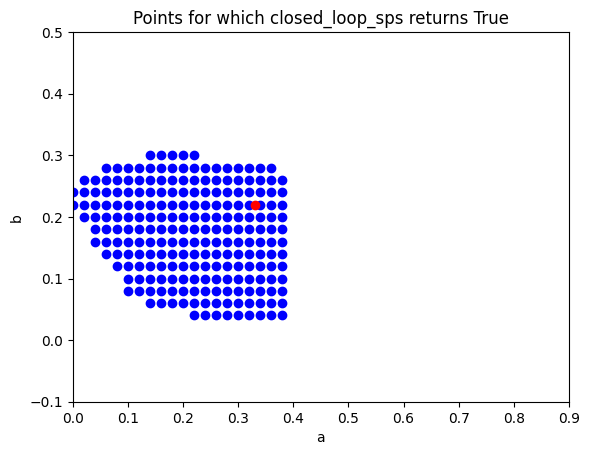

In [ ]:

C = cp.array([1, 0.15])         # C(z^-1) = 1 + 0.15z^-1
F = (cp.array([0.31, 0.23]), cp.array([1]))  # F(z^-1) = 0.31 + 0.23z^-1
L = (cp.array([1]), cp.array([1]))         # L(z^-1) = 1

m = 100
q = 5
T = n_samples
model = SPS_indirect_model(m, q)

# Create arrays for a and b values
a_values = cp.arange(0, 0.4, 0.02)
b_values = cp.arange(0, 0.4, 0.02)

# Create a meshgrid for a and b values
a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

# Flatten the grids for iteration
a_flat = a_grid.ravel()
b_flat = b_grid.ravel()

# Store results in a list
results = []

# Create torch tensors directly on GPU
a_torch = torch.tensor(a_flat, dtype=torch.float32, device=device)
b_torch = torch.tensor(b_flat, dtype=torch.float32, device=device)

# Vectorized operations to minimize Python loops
A_torch = torch.stack([torch.ones_like(a_torch), -a_torch], dim=-1)
B_torch = torch.stack([torch.zeros_like(b_torch), b_torch], dim=-1)

# Perform the operations in batch
A = cp.from_dlpack(A_torch)
B = cp.from_dlpack(B_torch)

# Assuming 'model' is predefined and contains the necessary methods
for i in range(len(a_flat)):
    G = (B[i], A[i])  # G should be a tuple of arrays
    H = (C, A[i])  # H should be a tuple of arrays

    # Transform to open loop
    G_0, H_0 = model.transform_to_open_loop(G, H, F, L)  # Assuming F and L are defined

    # Check the condition and store the result if true
    in_sps, S1 = model.open_loop_sps_2(G_0, H_0, Y, R, 1, 1)  # Assuming Y and U are defined
    if in_sps:
        results.append((a_flat[i].item(), b_flat[i].item()))
# Convert the results to a NumPy array
results = np.array(results)
# Plot the results
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
# axis limits
ax.set_xlim([0, 0.9])
ax.set_ylim([-0.1, 0.5])
ax.set_title('Points for which closed_loop_sps returns True')

# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()


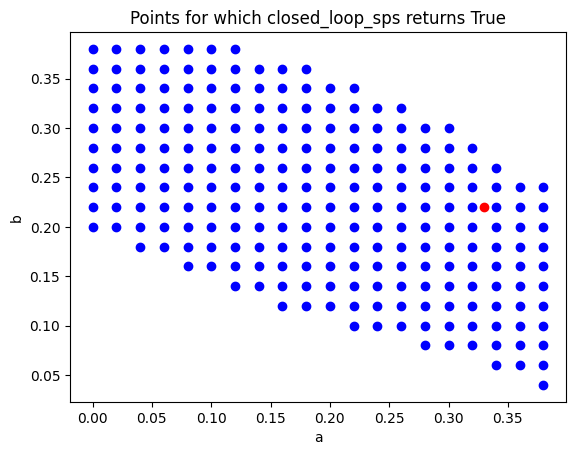

In [36]:
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
# axis limits
ax.set_title('Points for which closed_loop_sps returns True')

# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()


# Direct SPS implementation

In [7]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cub'

import os
import torch
try:
    torch.cuda.current_device()
    import cupy as cp
    from cupyx.scipy.linalg import solve_triangular
    from cupyx.scipy.signal import lfilter
except:
    # Fall back to unoptimised versions
    import numpy as cp
    from scipy.linalg import solve_triangular
    from scipy.signal import lfilter
    
cp.random.seed(42)
class d_tfs:
    def __init__(self, A):
        self.epsilon = cp.float64(1e-10)
        self.num = cp.asarray(A[0]).astype(self.epsilon.dtype)  # Ensure CuPy array
        self.den = cp.asarray(A[1]).astype(self.epsilon.dtype)   # Ensure CuPy array

    def __mul__(self, other):
        num = cp.convolve(self.num, other.num)  # Use cp.convolve for efficiency
        den = cp.convolve(self.den, other.den)
        return d_tfs((num, den))

    def add_scalar(self, scalar):
        # Multiply the denominator by the scalar
        scalar_denom = scalar * self.den
        # Ensure both polynomials have the same length by padding with zeros at the back
        if len(self.num) > len(scalar_denom):
            scalar_denom = cp.pad(scalar_denom, (0, len(self.num) - len(scalar_denom)))
        elif len(self.num) < len(scalar_denom):
            self.num = cp.pad(self.num, (0, len(scalar_denom) - len(self.num)))
        # Add the polynomials
        num_with_scalar = cp.polyadd(self.num, scalar_denom)
        return d_tfs((num_with_scalar, self.den))

    def __truediv__(self, other):
        num = cp.convolve(self.num, other.den)
        den = cp.convolve(self.den, other.num)
        return d_tfs((num, den))

    def __invert__(self):
        return d_tfs((self.den, self.num))

    def __str__(self):
        return f"Transfer Function: num={self.num}, den={self.den}"

    def __repr__(self):
        return self.__str__()

    def __call__(self, z):
        return cp.polyval(self.num, z) / cp.polyval(self.den, z)

    def apply_shift_operator(self, U_t):
        try:
            # Ensure input is a CuPy array
            U_t = cp.asarray(U_t)
            self.num += self.epsilon  # Add epsilon to avoid division by zero
            self.den += self.epsilon  # Add epsilon to avoid division by zero
            Y_t = lfilter(self.num, self.den, U_t)  # Use lfilter for filtering
            return cp.asarray(Y_t)
        except Exception as e:
            raise ValueError(f"Error applying shift operator: {e}")


class SPS_direct_model:
    def __init__(self, m, q, N=50):
        self.N = N
        self.m = m
        self.q = q
        self.alpha = cp.random.randn(m,N)
        self.alpha = cp.sign(self.alpha)
        self.alpha[0, :] = 1
        self.pi_order = cp.random.permutation(cp.arange(m))

    def create_phi_optimized(self, Y, U, n_a, n_b):
        m, t = Y.shape
        
        # Initialize phi with zeros
        phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
        
        # Handle Y lags
        for i in range(1, n_a + 1):
            phi[:, i:, i-1] = -1*Y[:, :-i]
        
        # Handle U lags
        for i in range(1, n_b + 1):
            phi[:, i:, n_a+i-1] = U[:-i]
        
        return phi
    
    # Returns (u_bar, Y_tilde) tuple
    def direct_sps(self, G, H, F, L, Y_t, R_t, n_a, n_b):
        G = d_tfs(G)
        H = d_tfs(H)
        F = d_tfs(F)
        L = d_tfs(L)
        
        try:
            Y_t = cp.asarray(Y_t)
            R_t = cp.asarray(R_t)

            # Regenerate the inputs
            N_hat = self.calculate_Nt(G, H, F, L, Y_t, R_t)
            N_hat_par = N_hat[-self.N:]

            # Perturb the inputs
            N_hat_bar = cp.multiply(self.alpha, N_hat_par)

            U_bar = self.calculate_U_bar(F, L, Y_t, R_t)
            U_bar_par = U_bar[-self.N-1:-1]
            
            Y_tilde = self.calculate_Y_bar(G, H, F, L, U_bar_par, N_hat_bar)
            Y_tilde = cp.asarray(Y_tilde)
            phi_tilde = self.create_phi_optimized(Y_tilde, U_bar_par, n_a, n_b)
            
            # Calculate SPS with new system inputs
            S = cp.zeros(self.m)
            for i in range(self.m):
                phi_col = phi_tilde[i]
                R_i = cp.matmul(phi_col.T, phi_col) / Y_tilde.shape[1]
                L = cp.linalg.cholesky(R_i)  # Cholesky decomposition to get lower-triangular L
                R_root_inv = solve_triangular(L, cp.eye(L.shape[0]), lower=True)  # Compute L_inv
                weighted_sum = cp.matmul(phi_tilde[i].T,N_hat_bar[i].reshape(-1,1))
                # norm squared
                S[i] = cp.sum(cp.square(cp.matmul(R_root_inv, weighted_sum)))

            combined = cp.array(list(zip(self.pi_order, S)))
            order= cp.lexsort(combined.T)
            rank_R = cp.where(order == 0)[0][0] + 1
            return rank_R <= self.m - self.q , S

        except Exception as e:
            print(e)
            pass

    def calculate_Nt(self, G: d_tfs, H: d_tfs, F: d_tfs, L: d_tfs, Y_t: cp.array, R_t: cp.array):
        # N_hat = H^-1*[(1+G*F)*Y_t - G*L*R_t]
        try:

            GLR = G.apply_shift_operator(L.apply_shift_operator(R_t))
            
            YGU = Y_t + F.apply_shift_operator(G.apply_shift_operator(Y_t)) - GLR
            N_hat = (~H).apply_shift_operator(YGU)

            return N_hat
        except Exception as e:
            raise ValueError(f"Error in direct SPS: {e}")

    def calculate_U_bar(self, F: d_tfs, L: d_tfs, Y_t: cp.array, R_t: cp.array):
        # U_bar = L*R_t - FY_bar
        try:

            U_bar = L.apply_shift_operator(R_t) - F.apply_shift_operator(Y_t)

            return U_bar
        except Exception as e:
            raise ValueError(f"Error in direct SPS: {e}")

    def calculate_Y_bar(self, G: d_tfs, H: d_tfs, F: d_tfs, L: d_tfs, U_bar: cp.array, N_t: cp.array):
        try:            
            Y_bar = [
                G.apply_shift_operator(U_bar) + (~H).apply_shift_operator(N_t[i])
                for i in range(self.m)
            ]

            return Y_bar
        except Exception as e:
            raise ValueError(f"Error in direct SPS: {e}")
        
        
# Example usage with CuPy:
A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

m = 100
q = 5
T = n_samples  # Example sample size

import cProfile, pstats
profiler = cProfile.Profile()

direct_model = SPS_direct_model(m, q)


# open loop system is 
# Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t
profiler.enable()
in_sps, S1 = direct_model.direct_sps(G, H, F, L, Y, U, 1, 1)
# print(f"SPS: {in_sps}")

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
profiler.clear()


         15143 function calls (14931 primitive calls) in 0.009 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.001    0.001    0.008    0.004 {method '__exit__' of 'sqlite3.Connection' objects}
      100    0.000    0.000    0.003    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\linalg\_basic.py:411(solve_triangular)
        1    0.000    0.000    0.002    0.002 C:\Users\Jake\AppData\Local\Temp\ipykernel_28088\1119117971.py:164(calculate_Y_bar)
      207    0.000    0.000    0.002    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\signal\_signaltools.py:1980(lfilter)
      100    0.001    0.000    0.002    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\linalg\_basic.py:503(_solve_triangular)
      621    0.000    0.000    0.001    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\signal\_signaltools.

## Direct SPS testing

In [37]:
profiler = cProfile.Profile()
profiler.enable()
in_sps, S1 = direct_model.direct_sps(G, H, F, L, Y, U, 1, 1)
# print(f"SPS: {in_sps}")

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
profiler.clear()

         14966 function calls (14961 primitive calls) in 0.015 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.005    0.002    0.010    0.005 {built-in method builtins.exec}
        1    0.000    0.000    0.006    0.006 C:\Users\Jake\AppData\Local\Temp\ipykernel_28088\2466995946.py:1(<module>)
        1    0.001    0.001    0.006    0.006 C:\Users\Jake\AppData\Local\Temp\ipykernel_28088\1119117971.py:97(direct_sps)
      207    0.000    0.000    0.004    0.000 C:\Users\Jake\AppData\Local\Temp\ipykernel_28088\724668055.py:58(apply_shift_operator)
        1    0.000    0.000    0.004    0.004 C:\Users\Jake\AppData\Local\Temp\ipykernel_28088\1119117971.py:164(calculate_Y_bar)
      207    0.000    0.000    0.004    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\signal\_signaltools.py:1980(lfilter)
      621    0.000    0.000    0.003    0.000 c:\Users\Jake\Learning-Dynamic-Systems\.

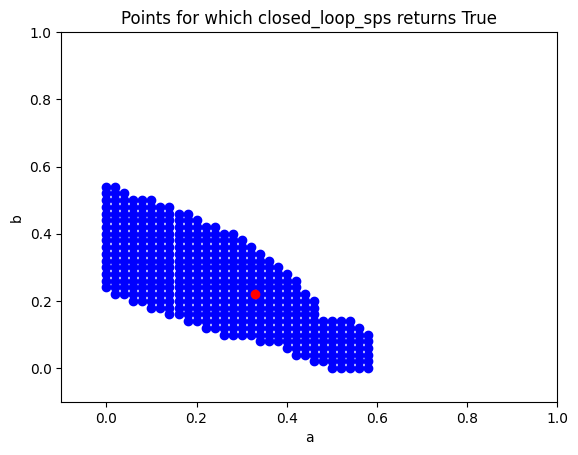

In [34]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cub'

import os
import torch
try:
    torch.cuda.current_device()
    import cupy as cp
    device = 'cuda'
except:
    # Fall back to unoptimised versions
    import numpy as cp
    device = None

C = cp.array([1, 0.15])         # C(z^-1) = 1 + 0.15z^-1
F = (cp.array([0.31, 0.23]), cp.array([1]))  # F(z^-1) = 0.31 + 0.23z^-1
L = (cp.array([1]), cp.array([1]))         # L(z^-1) = 1

m = 100
q = 5
T = n_samples
direct_model = SPS_direct_model(m, q)

# Create arrays for a and b values
a_values = cp.arange(0, 0.6, 0.02)
b_values = cp.arange(0, 0.6, 0.02)

# Create a meshgrid for a and b values
a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

# Flatten the grids for iteration
a_flat = a_grid.ravel()
b_flat = b_grid.ravel()

# Store results in a list
results = []

# Create torch tensors directly on GPU
a_torch = torch.tensor(a_flat, dtype=torch.float32, device=device)
b_torch = torch.tensor(b_flat, dtype=torch.float32, device=device)

# Vectorized operations to minimize Python loops
A_torch = torch.stack([torch.ones_like(a_torch), -a_torch], dim=-1)
B_torch = torch.stack([torch.zeros_like(b_torch), b_torch], dim=-1)

# Perform the operations in batch
A = cp.from_dlpack(A_torch)
B = cp.from_dlpack(B_torch)

# Assuming 'model' is predefined and contains the necessary methods
for i in range(len(a_flat)):
    G = (B[i], A[i])  # G should be a tuple of arrays
    H = (C, A[i])  # H should be a tuple of arrays

    # Check the condition and store the result if true
    in_sps, S1 = direct_model.direct_sps(G, H, F, L, Y, U, 1, 1)
    if in_sps:
        results.append((a_flat[i].item(), b_flat[i].item()))

# Convert the results to a NumPy array
results = np.array(results)
# Plot the results
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
# axis limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([-0.1, 1])
ax.set_title('Points for which closed_loop_sps returns True')

# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()


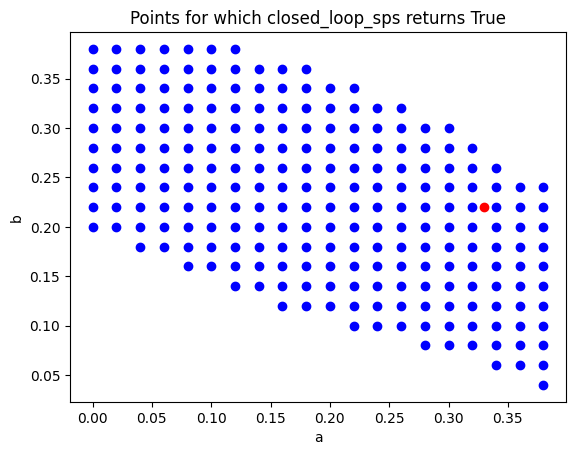

In [38]:
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
# axis limits
ax.set_title('Points for which closed_loop_sps returns True')

# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()


# benchmarks for different functions

In [102]:
from cupyx.profiler import benchmark
def create_phi():
    """
    Constructs a 3D array phi of shape (m, t, n_a + n_b) from input arrays Y and U.
    
    Parameters:
    - Y: CuPy array of shape (m, t), where m is the number of sequences and t is the length of each sequence.
    - U: CuPy array of shape (t,), representing the input sequence.
    - n_a: Integer, the number of previous values of Y to include in each phi_t.
    - n_b: Integer, the number of previous values of U to include in each phi_t.
    
    Returns:
    - phi: CuPy array of shape (m, t, n_a + n_b), the constructed 3D array.
    """
    # Example data
    m = 5  # Number of sequences
    t = 20  # Length of each sequence
    n_a = 3  # Number of previous values of Y
    n_b = 2  # Number of previous values of U

    # Create example CuPy arrays for Y and U
    Y = cp.random.rand(m, t)
    U = cp.random.rand(t)
    print(Y[0])
    print(U)

    def create_phi_optimized(Y, U, n_a, n_b):
        m, t = Y.shape
        
        # Initialize phi with zeros
        phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
        
        # Handle Y lags
        for i in range(1, n_a + 1):
            phi[:, i:, i-1] = Y[:, :-i]
        
        # Handle U lags
        for i in range(1, n_b + 1):
            phi[:, i:, n_a+i-1] = U[:-i]
        
        return phi
    def create_phi_optimized_2(Y, U, n_a, n_b):
        m, t = Y.shape
        
        # Initialize phi with zeros
        phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
        
        # Create index arrays
        y_indices = cp.arange(t)[:, None] - cp.arange(1, n_a + 1)
        u_indices = cp.arange(t)[:, None] - cp.arange(1, n_b + 1)
        
        # Clip indices to valid range
        y_indices = cp.clip(y_indices, 0, t - 1)
        u_indices = cp.clip(u_indices, 0, t - 1)
        
        # Create mask for valid entries
        y_mask = (cp.arange(t)[:, None] >= cp.arange(1, n_a + 1)).astype(Y.dtype)
        u_mask = (cp.arange(t)[:, None] >= cp.arange(1, n_b + 1)).astype(U.dtype)
        
        # Fill Y lags
        phi[:, :, :n_a] = Y[:, y_indices] * y_mask
        
        # Fill U lags
        phi[:, :, n_a:] = U[u_indices] * u_mask
        
        return phi

    methods = [create_phi_optimized, create_phi_optimized_2]
    for method in methods:
        print(f"Method: {method.__name__}")
        print(benchmark(method, (Y, U, n_a, n_b), n_repeat=1000))
    




        # Initialize phi with zeros
    # phi = cp.zeros((Y.shape[0], Y.shape[1], n_a + n_b), dtype=Y.dtype)
    # # Fill phi with the appropriate lagged values
    # for t in range(min(n_a, n_b), Y.shape[1]):
    #     # Extract the previous n_a values of Y
    #     Y_lags = cp.zeros((Y.shape[0], n_a), dtype=Y.dtype)
    #     if t >= n_a:
    #         Y_lags[:, :] = Y[:, t-n_a:t]
        
    #     # Extract the previous n_b values of U
    #     U_lags = cp.zeros((n_b,), dtype=U.dtype)
    #     if t >= n_b:
    #         U_lags[:] = U[t-n_b:t]
    #     U_lags = cp.tile(U_lags[None, :], (Y.shape[0], 1))
    #     # Concatenate Y_lags and U_lags to form phi_t
    #     phi_t = cp.concatenate([Y_lags, U_lags ], axis=1)
    #     # Store phi_t in the corresponding slice of phi
    #     print(t-max(n_a, n_b))
    #     phi[:, t, :] = phi_t



# Create phi
create_phi()


[0.83563212 0.45545616 0.20276454 0.00221818 0.856313   0.44175708
 0.68984781 0.05433224 0.42697821 0.19565076 0.33039593 0.97315701
 0.5468635  0.86663865 0.21054968 0.93884639 0.63208523 0.8614563
 0.31144366 0.57810279]
[0.7833139  0.1821845  0.72398885 0.77988199 0.57536508 0.95228893
 0.03658332 0.2406056  0.61153948 0.22965813 0.86163331 0.32835235
 0.8361165  0.22372303 0.20211115 0.6844918  0.00209324 0.18962914
 0.67935658 0.2658095 ]
Method: create_phi_optimized
create_phi_optimized:    CPU:   332.399 us   +/- 70.580 (min:   219.700 / max:  1257.200) us     GPU-0:   375.658 us   +/- 240.860 (min:    65.408 / max:  2463.552) us
Method: create_phi_optimized_2
create_phi_optimized_2:    CPU:  1819.945 us   +/- 243.100 (min:  1468.400 / max:  3586.600) us     GPU-0:  1931.202 us   +/- 525.659 (min:   299.584 / max:  4778.432) us


In [ ]:
from cupyx.profiler import benchmark

def method_1(Y, U, n_a, n_b):
    """
    Constructs the phi array using a loop-based approach.
    """
    m, t = Y.shape
    phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
    for i in range(n_a, t):
        Y_lags = Y[:, i - n_a:i]
        U_lags = U[i - n_b:i]
        phi[:, i, :] = cp.concatenate([Y_lags, U_lags[None, :]], axis=1)
    return phi


def method_1(Y, U, n_a, n_b):
    """
    Constructs a 3D array phi of shape (m, t, n_a + n_b) from input arrays Y and U.
    
    Parameters:
    - Y: CuPy array of shape (m, t), where m is the number of sequences and t is the length of each sequence.
    - U: CuPy array of shape (t,), representing the input sequence.
    - n_a: Integer, the number of previous values of Y to include in each phi_t.
    - n_b: Integer, the number of previous values of U to include in each phi_t.
    
    Returns:
    - phi: CuPy array of shape (m, t, n_a + n_b), the constructed 3D array.
    """
    # Initialize phi with zeros
    m , t = Y.shape
    phi = cp.zeros((m, t, n_a + n_b), dtype=Y.dtype)
    # Fill phi with the appropriate lagged values
    for t in range(min(n_a, n_b)-1, Y.shape[1]):
        # Extract the previous n_a values of Y
        Y_lags = cp.zeros((m, n_a), dtype=Y.dtype)
        if t >= n_a-1:
            Y_lags[:, :] = Y[:, t-n_a:t]
        
        # Extract the previous n_b values of U
        U_lags = cp.zeros((n_b,), dtype=U.dtype)
        if t >= n_b-1:
            U_lags[:] = U[t-n_b:t]
        U_lags = cp.tile(U_lags[None, :], (Y.shape[0], 1))
        # Concatenate Y_lags and U_lags to form phi_t
        phi_t = cp.concatenate([Y_lags, U_lags ], axis=1)
        # Store phi_t in the corresponding slice of phi
        print(t-max(n_a, n_b))
        phi[:, t, :] = phi_t

    return phi

def method_2(Y, U, n_a, n_b):
    """
    Constructs the phi array using vectorized operations.
    """
    m, t = Y.shape
    Y_lags = cp.array([Y[:, i - n_a:i] for i in range(n_a, t)])
    U_lags = cp.array([U[i - n_b:i] for i in range(n_b, t)])
    phi = cp.concatenate([Y_lags, U_lags], axis=-1)
    return phi

def method_3(Y, U, n_a, n_b):
    """
    Constructs the phi array using advanced indexing.
    """
    m, t = Y.shape
    Y_lags = cp.array([Y[:, i - n_a:i] for i in range(n_a, t)])
    U_lags = cp.array([U[i - n_b:i] for i in range(n_b, t)])
    phi = cp.concatenate([Y_lags, U_lags], axis=-1)
    return phi

def optimize_phi_calculation(Y, U, n_a, n_b):
    # Initialize phi with zeros
    phi = cp.zeros((Y.shape[0], Y.shape[1], n_a + n_b), dtype=Y.dtype)
    
    # Calculate the starting index for filling phi
    start_idx = max(n_a, n_b)
    
    # Create indices for Y lags
    y_indices = cp.arange(n_a)[None, :] + cp.arange(Y.shape[1] - start_idx)[:, None]
    
    # Fill Y lags in phi
    phi[:, start_idx:, :n_a] = Y[:, y_indices].transpose(0, 2, 1)
    
    # Create indices for U lags
    u_indices = cp.arange(n_b)[None, :] + cp.arange(Y.shape[1] - start_idx)[:, None]
    
    # Fill U lags in phi
    phi[:, start_idx:, n_a:] = cp.tile(U[u_indices], (Y.shape[0], 1, 1))

    return phi

# Usage
# Example data
m = 5  # Number of sequences
t = 20  # Length of each sequence
n_a = 3  # Number of previous values of Y
n_b = 2  # Number of previous values of U

Y_test = cp.random.rand(m, t)
U_test = cp.random.rand(t)

# List of methods to benchmark
methods = [method_1, method_2, method_3, optimize_phi_calculation]

# Benchmark each method
for method in methods:
    print(f"Benchmarking {method.__name__}:")
    print(method(Y_test, U_test, n_a, n_b))
    # result = benchmark(method, (Y_test, U_test, n_a, n_b), n_repeat=10)
    # print(result)
    # print()


Benchmarking method_1:


ValueError: All arrays must have same shape except the axis to concatenate

In [13]:
from cupyx.profiler import benchmark

# Define the dimensions
M = 1000  # Example value for M
N = 1000  # Example value for N

def method_choice():
    h = cp.random.choice([-1, 1], size=(M, N))
    h[0, :] = 1
    return h

def method_sign():
    random_array = cp.random.randn(M, N)
    h = cp.sign(random_array)
    h[0, :] = 1
    return h

def method_vstack():
    # Generate an (M-1)-by-N array of random numbers from a standard normal distribution
    random_array = cp.random.randn(M - 1, N)

    # Apply the sign function to obtain -1 or 1
    signed_random_array = cp.sign(random_array)

    # Prepend a row of ones
    ones_row = cp.ones((1, N))
    h = cp.vstack((ones_row, signed_random_array))
    return h

methods = [method_choice, method_sign, method_vstack]
n_repeat = 1000
for method in methods:
    print(f"Benchmarking {method.__name__}")
    print(benchmark(method, n_repeat=n_repeat))

Benchmarking method_choice
method_choice       :    CPU:   788.355 us   +/- 235.711 (min:   449.900 / max:  1754.300) us     GPU-0:  2540.209 us   +/- 1028.177 (min:  2116.544 / max: 17078.497) us
Benchmarking method_sign
method_sign         :    CPU:   223.038 us   +/- 78.635 (min:   107.400 / max:   747.000) us     GPU-0:  1259.200 us   +/- 209.137 (min:  1134.208 / max:  3440.640) us
Benchmarking method_vstack
method_vstack       :    CPU:   370.047 us   +/- 114.688 (min:   203.600 / max:  1017.500) us     GPU-0:  1863.616 us   +/- 301.836 (min:  1689.120 / max:  4055.008) us


In [ ]:

# Convert the results to a NumPy array
results = np.array(results)
# Plot the results
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_title('Points for which open_loop_sps returns True')
ax.set_xlim([0.3, 0.5])
ax.set_ylim([-0.1, 0.5])
# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()